# Access Sentinel 6 Data in the Cloud
##### Notebook Author: Julie Sanchez, NASA PO.DAAC (May 2024)

## Summary
#### This notebook will show direct access of PO.DAAC archived products in the Earthdata Cloud in AWS Simple Storage Service (S3). 
#### In this demo, we will showcase the usage of the Sentinel 6 product: 
#### Sentinel-6A MF Jason-CS L2 P4 Altimeter Low Resolution (LR) NTC Ocean Surface Topography F08 Data Product - shortname JASON_CS_S6A_L2_ALT_LR_STD_OST_NTC_F08
#### We will access the data from inside the AWS cloud (us-west-2 region, specifically) and plot the sea surface height anomaly.

## Requirement
#### This tutorial can only be run in an AWS cloud instance running in us-west-2 region.

## Learning Objectives:
#### Authenticate for earthaccess Python Library using your NASA Earthdata Login 
#### Access DAAC data directly from the in-region S3 bucket without moving or downloading any files to your local (cloud) workspace 
#### Note: no files are being downloaded off the cloud, rather, we are working with the data in the AWS cloud.

## Libraries Needed:

In [26]:
import xarray as xr
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
import earthaccess
from earthaccess import Auth, DataCollections, DataGranules, Store
%matplotlib inline

## Earthdata Login
#### An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up. We use earthaccess to authenticate your login credentials below.

In [27]:
auth = earthaccess.login() 

## 1. Sentinel 6A Sea Surface Height Anomaly Data
## Access Files without any Downloads to your running instance
#### Here, we use the earthaccess Python library to search for without downloading any files. 

In [28]:
#contain links for each granules
ssh_data = earthaccess.search_data(short_name = 'JASON_CS_S6A_L2_ALT_LR_STD_OST_NTC_F08',
                                        temporal = ("2023-02-18 12:00:00", "2023-02-19 12:00:00"),
                                        )

Granules found: 22


## Extract and grab first link (URL)

In [29]:
# extracting links (url)
data_links = [granule.data_links(access="direct") for granule in ssh_data]

#picks first one
file_path = data_links[0] 
file_path

['s3://podaac-ops-cumulus-protected/JASON_CS_S6A_L2_ALT_LR_STD_OST_NTC_F08/S6A_P4_2__LR_STD__NT_084_001_20230218T160856_20230218T170509_F08.nc']

## Authenticate from AWS

In [30]:
#authenticate and get short term credientials to bucket (podaac-ops...)
fs_s3 = earthaccess.get_s3fs_session(results=ssh_data)

## Read file

In [31]:
#reading file into memory
fs_s3.open(file_path[0])

<File-like object S3FileSystem, podaac-ops-cumulus-protected/JASON_CS_S6A_L2_ALT_LR_STD_OST_NTC_F08/S6A_P4_2__LR_STD__NT_084_001_20230218T160856_20230218T170509_F08.nc>

## Load with xarray

In [32]:
# Load the netCDF file using xarray
ku_ds = xr.open_dataset(fs_s3.open(file_path[0]), group = 'data_01/ku')
c_ds = xr.open_dataset(fs_s3.open(file_path[0]), group = 'data_01/c')
data01_ds = xr.open_dataset(fs_s3.open(file_path[0]), group = 'data_01')


## Plot sea surface height anomaly (ssha)

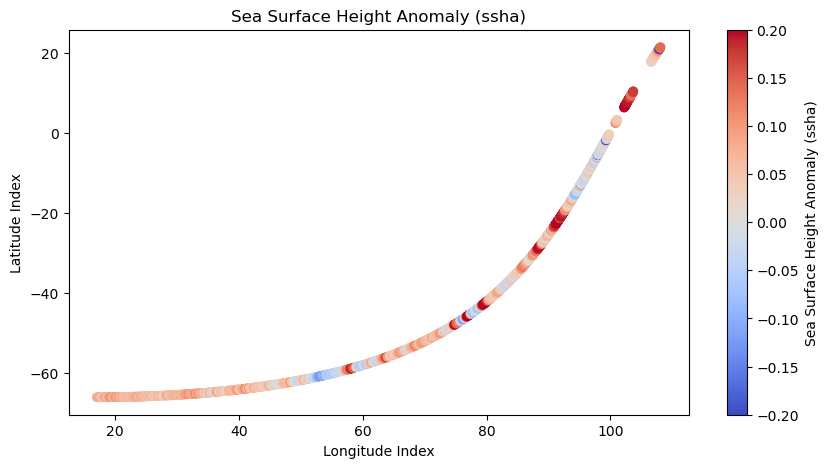

In [35]:
# Access the 'ssha' variable under 'data_01' and 'ku'
ssha = ku_ds['ssha']

# Plot the 'ssha'
plt.figure(figsize=(10, 5))
plt.scatter(data01_ds.longitude, data01_ds.latitude, c = ssha, cmap = 'coolwarm', vmin=-0.2, vmax=0.2)
plt.colorbar(label='Sea Surface Height Anomaly (ssha)')
plt.title('Sea Surface Height Anomaly (ssha)')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()

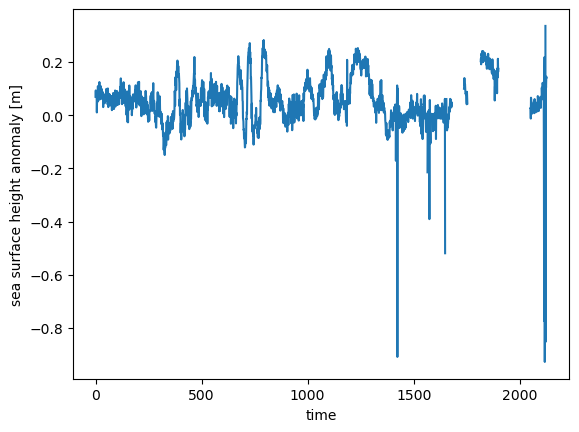

In [22]:
ssha.plot()

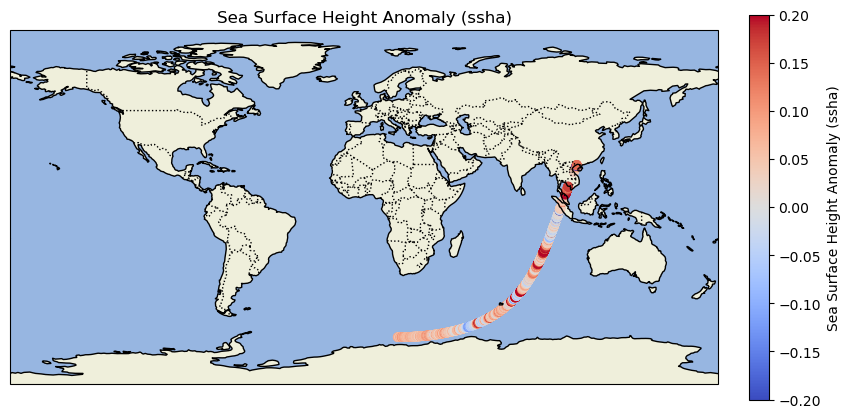

In [36]:
# Create a plot with a specific projection
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Set the extent to global

# Add features to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)  # Correct attribute for oceans
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the 'ssha' with longitude and latitude from your dataset
scatter = ax.scatter(data01_ds.longitude, data01_ds.latitude, c=ssha, cmap='coolwarm', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Sea Surface Height Anomaly (ssha)')

# Set titles and labels
plt.title('Sea Surface Height Anomaly (ssha)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()